In [1]:
# here we load a pretrained MobilenetV2 model and get the feature map
# https://github.com/d-li14/mobilenetv2.pytorch
from torchvision import models
import torch
model = models.mobilenet_v2(pretrained=True)
# save the pretrained weight
torch.save(model.state_dict(), './Weights/pretrained_mobilenetv2_imagenet.pth')
# dataloader imagenet
from Dataloaders.dataloader_imagenet import Dataset_imagenet, Dataloader_imagenet
imagenet = Dataset_imagenet('home')
_, test, _ = imagenet.return_sampler()
_, test_set, _ = imagenet.return_dict()

torch.seed()
test_loader = Dataloader_imagenet(test, test_set, transform = True)
test_loader = torch.utils.data.DataLoader(test_loader, batch_size=100, shuffle=True)

model = model.cuda()
model.eval()
# get the first image
labels = torch.tensor([])
outputs = torch.tensor([])
for ind, (image, label) in enumerate(test_loader):
    labels = torch.cat((labels, label))
    image = image.cuda()
    output = model(image)
    outputs = torch.cat((outputs, output.cpu().detach()), dim=0)
    if ind == 0:
        break
# forward pass
output = model(image)
# get the max
max_output = torch.argmax(output, dim=1).cpu().detach()
print(max_output==label)

/home/tonypeng/anaconda3/envs/iot/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tonypeng/anaconda3/envs/iot/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
        False,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True, False,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True, False, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True])


In [2]:
from Models.mobilenetv2_original import stupid_model_splitter
import numpy as np
client, server = stupid_model_splitter(weight_path='./Weights/pretrained_mobilenetv2_imagenet.pth')
# forward pass
client = client.cuda()
server = server.cuda()
client.eval()
server.eval()
client_output = client(image).cpu().detach()
original_output = client(image).cpu().detach()
server_output = server(original_output).cpu().detach()
# check if the output is the same
# count zeros
result = np.sum(np.where(client_output==0, 1, 0))
print(result)
print(client_output.shape)
print(result/np.prod(client_output.shape))

# check is a channel is all zeros
zero_channels = 0
for i in range (client_output.shape[0]):
    for j in range (client_output.shape[1]):
        if torch.sum(client_output[i,j,:,:])==0:
            zero_channels+=1
print(zero_channels)

RuntimeError: Error(s) in loading state_dict for MobileNetV2_server:
	Missing key(s) in state_dict: "features.0.conv.0.0.weight", "features.0.conv.0.1.weight", "features.0.conv.0.1.bias", "features.0.conv.0.1.running_mean", "features.0.conv.0.1.running_var", "features.0.conv.1.weight", "features.0.conv.2.weight", "features.0.conv.2.bias", "features.0.conv.2.running_mean", "features.0.conv.2.running_var", "features.1.conv.1.0.weight", "features.1.conv.1.1.weight", "features.1.conv.1.1.bias", "features.1.conv.1.1.running_mean", "features.1.conv.1.1.running_var", "features.1.conv.3.weight", "features.1.conv.3.bias", "features.1.conv.3.running_mean", "features.1.conv.3.running_var", "features.17.0.weight", "features.17.1.weight", "features.17.1.bias", "features.17.1.running_mean", "features.17.1.running_var". 
	size mismatch for features.1.conv.0.0.weight: copying a param with shape torch.Size([32, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([96, 16, 1, 1]).
	size mismatch for features.1.conv.0.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for features.1.conv.0.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for features.1.conv.0.1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for features.1.conv.0.1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for features.1.conv.2.weight: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([24, 96, 1, 1]).
	size mismatch for features.2.conv.0.0.weight: copying a param with shape torch.Size([96, 16, 1, 1]) from checkpoint, the shape in current model is torch.Size([144, 24, 1, 1]).
	size mismatch for features.2.conv.0.1.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for features.2.conv.0.1.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for features.2.conv.0.1.running_mean: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for features.2.conv.0.1.running_var: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for features.2.conv.1.0.weight: copying a param with shape torch.Size([96, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([144, 1, 3, 3]).
	size mismatch for features.2.conv.1.1.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for features.2.conv.1.1.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for features.2.conv.1.1.running_mean: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for features.2.conv.1.1.running_var: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for features.2.conv.2.weight: copying a param with shape torch.Size([24, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([24, 144, 1, 1]).
	size mismatch for features.3.conv.2.weight: copying a param with shape torch.Size([24, 144, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 144, 1, 1]).
	size mismatch for features.3.conv.3.weight: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for features.3.conv.3.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for features.3.conv.3.running_mean: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for features.3.conv.3.running_var: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for features.4.conv.0.0.weight: copying a param with shape torch.Size([144, 24, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 32, 1, 1]).
	size mismatch for features.4.conv.0.1.weight: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.4.conv.0.1.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.4.conv.0.1.running_mean: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.4.conv.0.1.running_var: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.4.conv.1.0.weight: copying a param with shape torch.Size([144, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([192, 1, 3, 3]).
	size mismatch for features.4.conv.1.1.weight: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.4.conv.1.1.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.4.conv.1.1.running_mean: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.4.conv.1.1.running_var: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.4.conv.2.weight: copying a param with shape torch.Size([32, 144, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 192, 1, 1]).
	size mismatch for features.6.conv.2.weight: copying a param with shape torch.Size([32, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 192, 1, 1]).
	size mismatch for features.6.conv.3.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.6.conv.3.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.6.conv.3.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.6.conv.3.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.7.conv.0.0.weight: copying a param with shape torch.Size([192, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([384, 64, 1, 1]).
	size mismatch for features.7.conv.0.1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for features.7.conv.0.1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for features.7.conv.0.1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for features.7.conv.0.1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for features.7.conv.1.0.weight: copying a param with shape torch.Size([192, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([384, 1, 3, 3]).
	size mismatch for features.7.conv.1.1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for features.7.conv.1.1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for features.7.conv.1.1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for features.7.conv.1.1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for features.7.conv.2.weight: copying a param with shape torch.Size([64, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 384, 1, 1]).
	size mismatch for features.10.conv.2.weight: copying a param with shape torch.Size([64, 384, 1, 1]) from checkpoint, the shape in current model is torch.Size([96, 384, 1, 1]).
	size mismatch for features.10.conv.3.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for features.10.conv.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for features.10.conv.3.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for features.10.conv.3.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for features.11.conv.0.0.weight: copying a param with shape torch.Size([384, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([576, 96, 1, 1]).
	size mismatch for features.11.conv.0.1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.11.conv.0.1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.11.conv.0.1.running_mean: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.11.conv.0.1.running_var: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.11.conv.1.0.weight: copying a param with shape torch.Size([384, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([576, 1, 3, 3]).
	size mismatch for features.11.conv.1.1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.11.conv.1.1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.11.conv.1.1.running_mean: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.11.conv.1.1.running_var: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.11.conv.2.weight: copying a param with shape torch.Size([96, 384, 1, 1]) from checkpoint, the shape in current model is torch.Size([96, 576, 1, 1]).
	size mismatch for features.13.conv.2.weight: copying a param with shape torch.Size([96, 576, 1, 1]) from checkpoint, the shape in current model is torch.Size([160, 576, 1, 1]).
	size mismatch for features.13.conv.3.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.13.conv.3.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.13.conv.3.running_mean: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.13.conv.3.running_var: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.14.conv.0.0.weight: copying a param with shape torch.Size([576, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([960, 160, 1, 1]).
	size mismatch for features.14.conv.0.1.weight: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.14.conv.0.1.bias: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.14.conv.0.1.running_mean: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.14.conv.0.1.running_var: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.14.conv.1.0.weight: copying a param with shape torch.Size([576, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([960, 1, 3, 3]).
	size mismatch for features.14.conv.1.1.weight: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.14.conv.1.1.bias: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.14.conv.1.1.running_mean: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.14.conv.1.1.running_var: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.14.conv.2.weight: copying a param with shape torch.Size([160, 576, 1, 1]) from checkpoint, the shape in current model is torch.Size([160, 960, 1, 1]).
	size mismatch for features.16.conv.2.weight: copying a param with shape torch.Size([160, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([320, 960, 1, 1]).
	size mismatch for features.16.conv.3.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([320]).
	size mismatch for features.16.conv.3.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([320]).
	size mismatch for features.16.conv.3.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([320]).
	size mismatch for features.16.conv.3.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([320]).

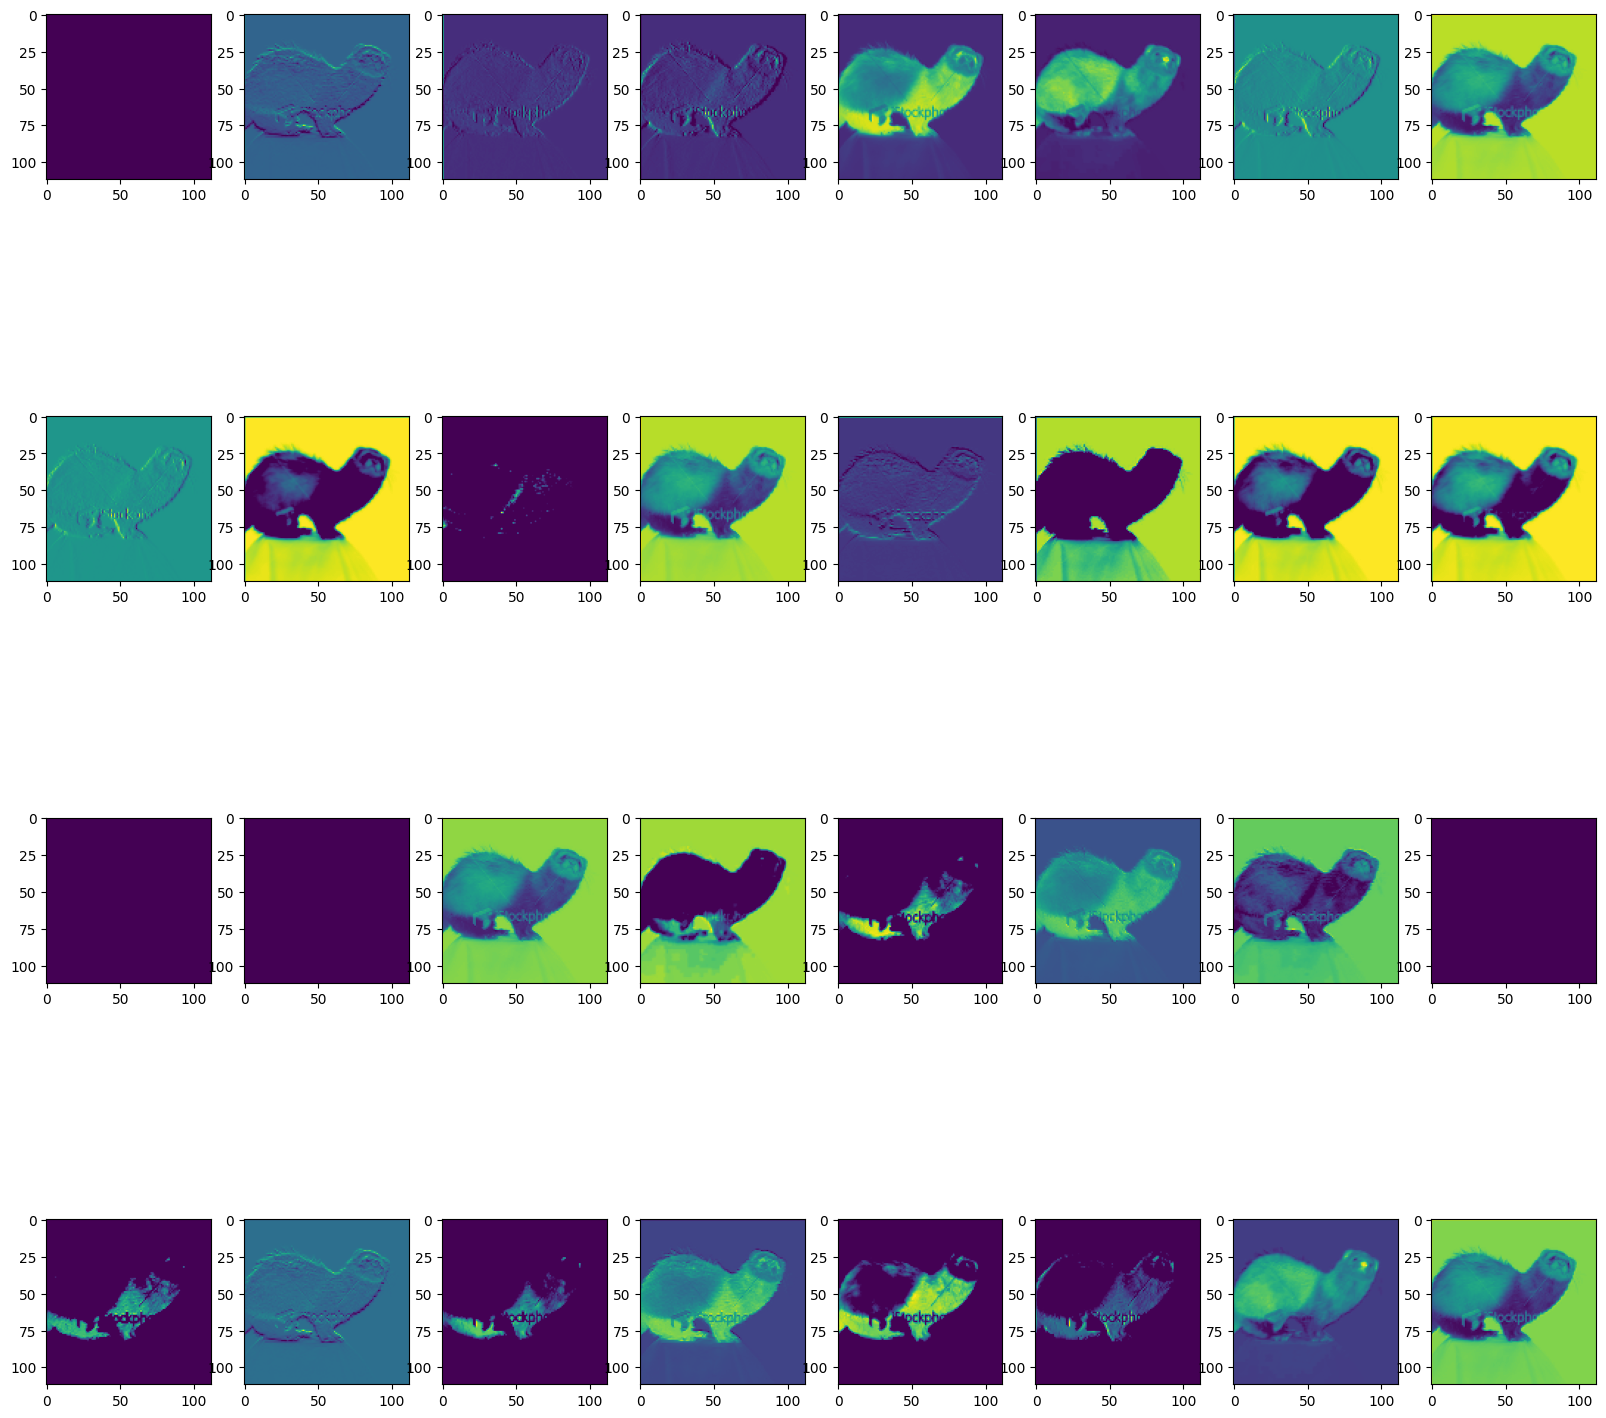

In [ ]:
# plot the all feature map
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(4,8, figsize=(20,20))
for i in range(4):
    for j in range(8):
        axs[i,j].imshow(client_output[0,i*8+j,:,:].detach().numpy())

plt.show()

torch.Size([112, 112])


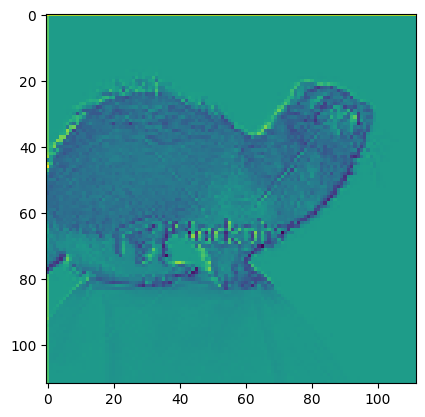

In [ ]:
# wanna add all channels together and see the result, simply add
cat_img = client_output[0,:,:,:]
cat_img = torch.sum(cat_img, dim=0)
print(cat_img.shape)
plt.imshow(cat_img.detach().numpy())

tensor(1.)


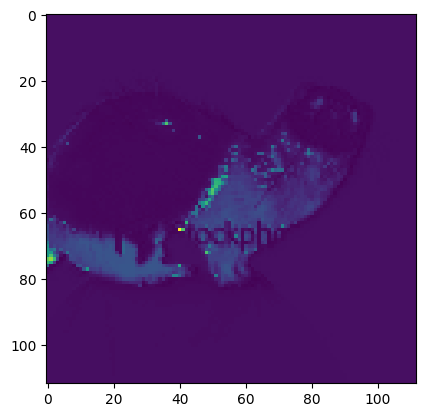

In [ ]:
# cat image add based on the sum of the channel
cat_weight = client_output[0,:,:,:] # 32,112,112
cat_weight = torch.sum(cat_weight, dim=[1,2])
cat_weight = np.where(cat_weight==0, 1, cat_weight)

cat_img = client_output[0,:,:,:] / cat_weight[:,None,None]
cat_img = torch.sum(cat_img, dim=0)
cat_img = cat_img/torch.max(cat_img)
plt.imshow(cat_img.detach().numpy())
print(torch.max(cat_img))

In [ ]:
cat_img = cat_img.detach().numpy()

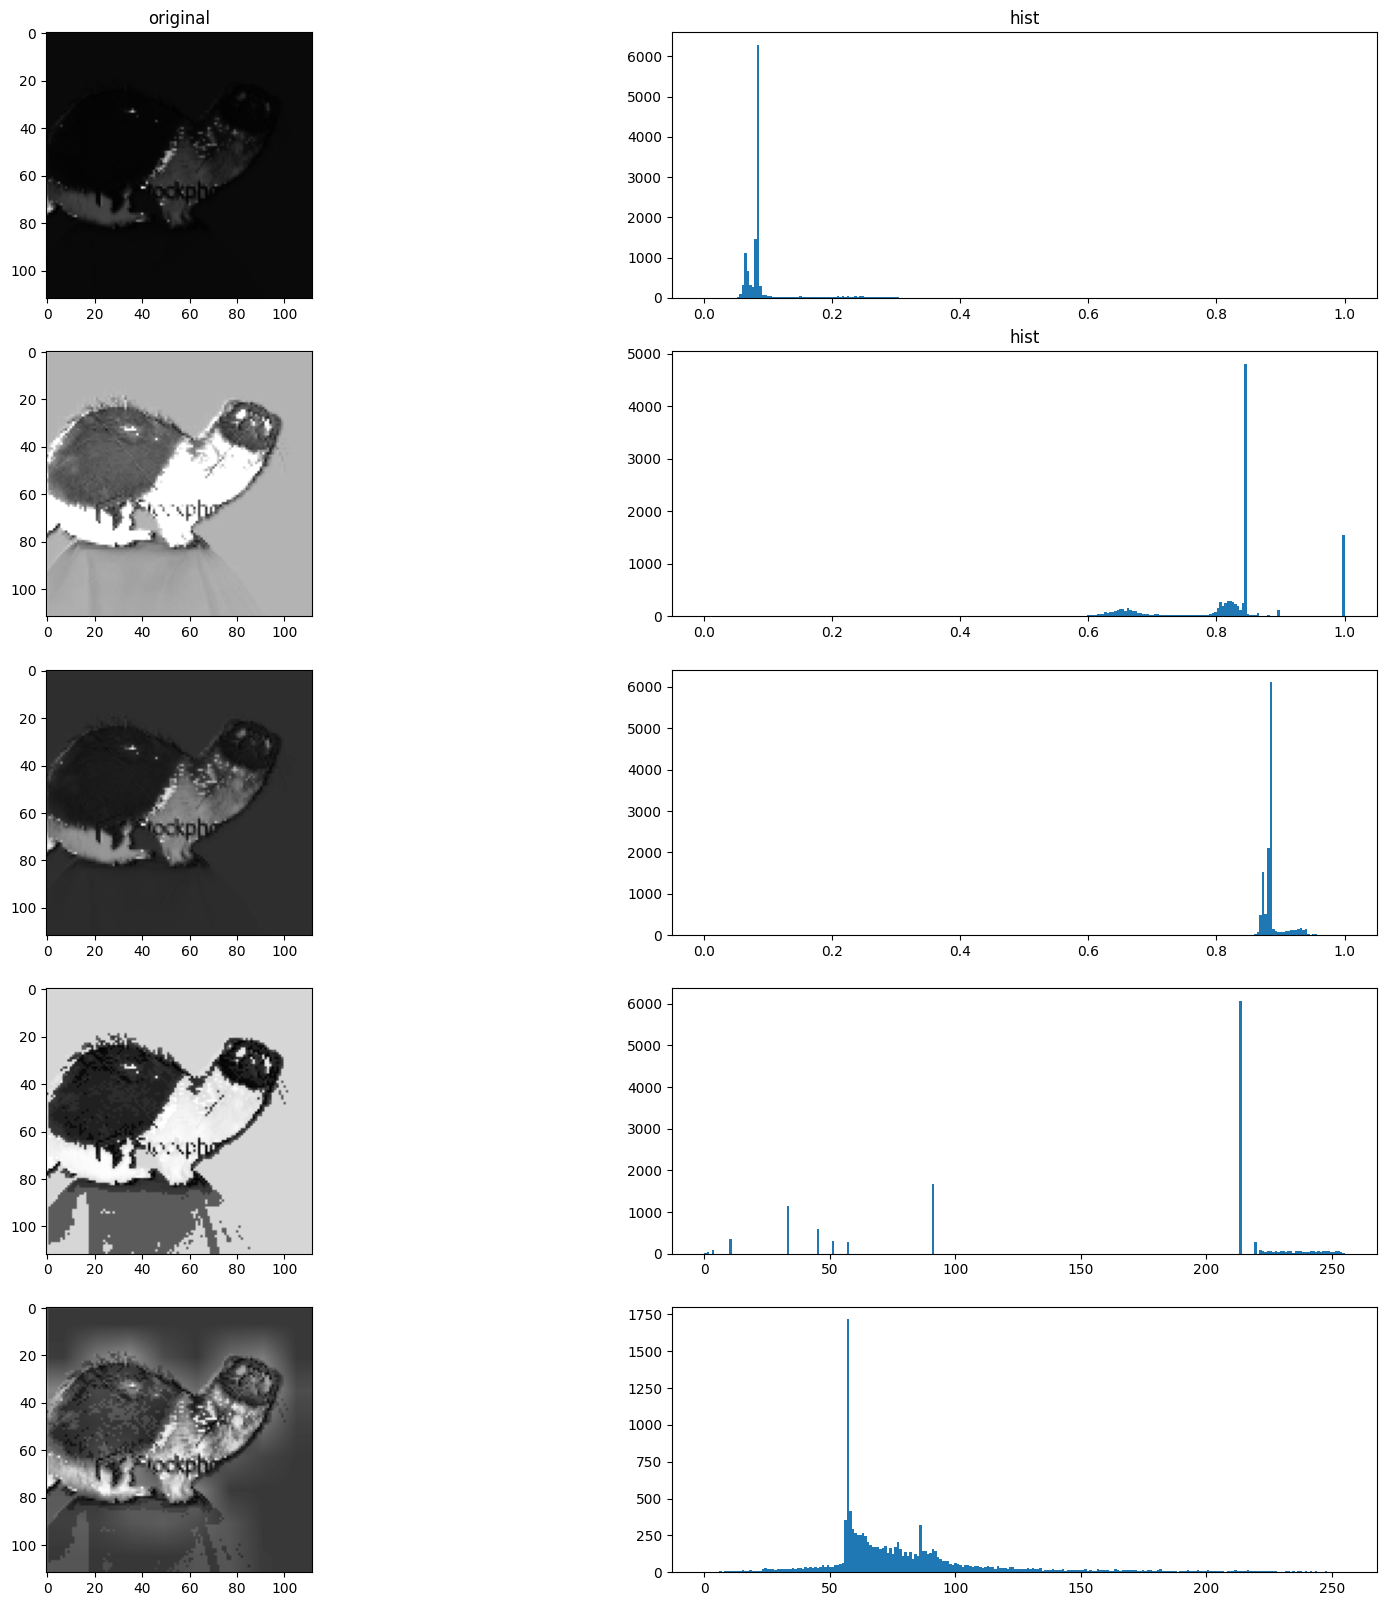

In [ ]:
# hist constract
import cv2
# plot 6 images, subplot
fig, axs = plt.subplots(5,2, figsize=(20,20))
rescale = cv2.calcHist([cat_img], [0], None, [256], [0, 1])
axs[0,0].imshow(cat_img, cmap='gray')
axs[0,0].set_title('original')

# hist
axs[0,1].hist(cat_img.flatten(), bins=256, range=[0,1])
axs[0,1].set_title('hist')

# linear 
a = 10
temp_cat = cat_img*a
temp_cat = np.where(temp_cat>1, 1, temp_cat)
axs[1,0].imshow(temp_cat, cmap='gray')
axs[1,1].hist(temp_cat.flatten(), bins=256, range=[0,1])
axs[1,1].set_title('hist')

# gamma
gamma = 0.05
temp_cat = cat_img**gamma
temp_cat = np.where(temp_cat>1, 1, temp_cat)
axs[2,0].imshow(temp_cat, cmap='gray')
axs[2,1].hist(temp_cat.flatten(), bins=256, range=[0,1])

# global hist equalization 
# def equalizeHist(img):
#     H,W = img.shape
#     S = H*W
#     out = np.zeros((H,W), dtype=np.int8)
#     sum_h = 0
#     img =img*255
#     img = img.astype(np.uint8)
#     for i in range(256):
#         ind = np.where(img == i)
#         sum_h += len(img[ind])
#         z_prime = (255/S)*sum_h
#         out[ind] = z_prime
#     return out
# temp_cat = equalizeHist(cat_img)
# axs[3,0].imshow(temp_cat, cmap='gray')

temp_cat = cv2.equalizeHist((cat_img*255).astype(np.uint8))
axs[3,0].imshow(temp_cat, cmap='gray')
axs[3,1].hist(temp_cat.flatten(), bins=256, range=[0,255])

# CLAHE
clahe = cv2.createCLAHE(clipLimit=30.0, tileGridSize=(8,8))
dst = clahe.apply((cat_img*255).astype(np.uint8))
axs[4,0].imshow(dst, cmap='gray')
axs[4,1].hist(dst.flatten(), bins=256, range=[0,255])

plt.show()

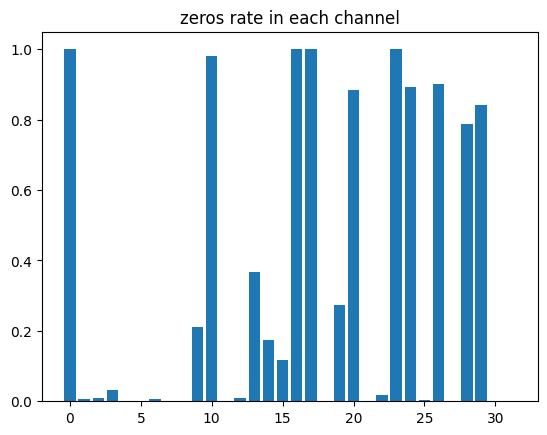

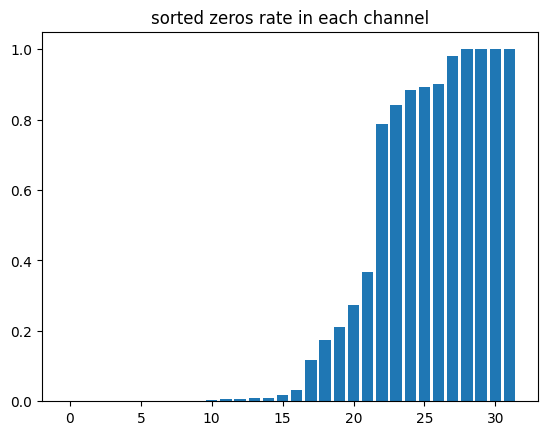

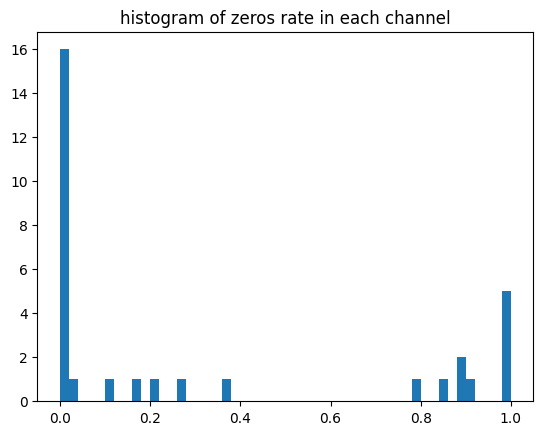

In [ ]:
# check the zeros in a feature map
cat_img = client_output[0,:,:,:] 
# check the zeros rate in each channel
zero_rate = np.zeros(cat_img.shape[0])
for i in range(cat_img.shape[0]):
    zero_rate[i] = np.sum(np.where(cat_img[i,:,:]==0, 1, 0))/np.prod(cat_img.shape[1:])
x = np.arange(cat_img.shape[0])
plt.bar(x, zero_rate)
plt.title('zeros rate in each channel')
# print sorted and hist
zero_rate = np.sort(zero_rate)
plt.figure()
plt.bar(x, zero_rate)
plt.title('sorted zeros rate in each channel')
plt.figure()
plt.hist(zero_rate, bins=50)
plt.title('histogram of zeros rate in each channel')
plt.show()


In [ ]:
# check if set the channel which has over 50% zeros to all zeros
for i, d in enumerate(client_output):
    zero_rate = np.zeros(client_output[i].shape[0])
    for j in range(client_output[i].shape[0]):
        zeros = np.where(client_output[i,j,:,:]==0, 1, 0)
        sizes = np.prod(client_output[i,j,:,:].shape)
        zero_rate[j] = np.sum(zeros)/sizes
    # set the channel to zeros
        if zero_rate[j]>0.5:
            client_output[i,j,:,:] = 0
    # calculate the number of channels which has over 50% zeros

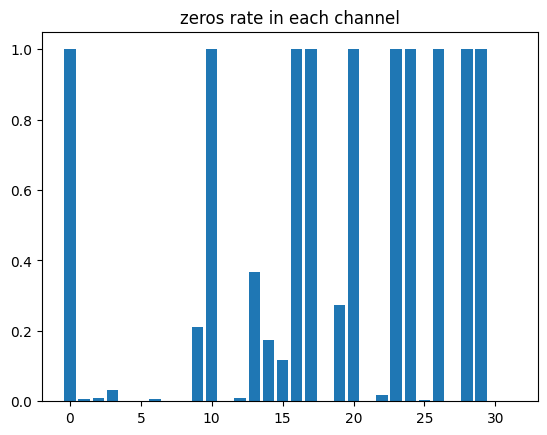

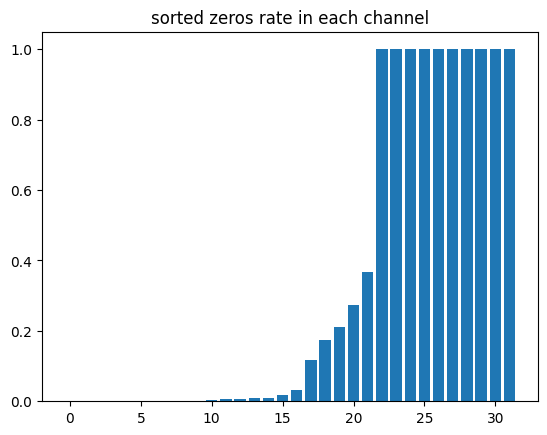

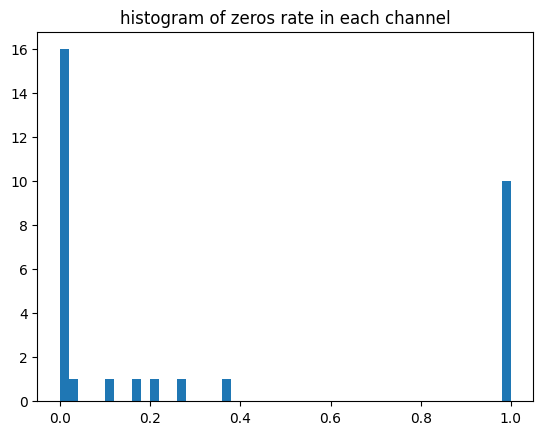

In [ ]:
np.sum(np.where(client_output==0, 1, 0)/np.prod(client_output.shape))
# check the zeros in a feature map
cat_img = client_output[0,:,:,:] 
# check the zeros rate in each channel
zero_rate = np.zeros(cat_img.shape[0])
for i in range(cat_img.shape[0]):
    zero_rate[i] = np.sum(np.where(cat_img[i,:,:]==0, 1, 0))/np.prod(cat_img.shape[1:])
x = np.arange(cat_img.shape[0])
plt.bar(x, zero_rate)
plt.title('zeros rate in each channel')
# print sorted and hist
zero_rate = np.sort(zero_rate)
plt.figure()
plt.bar(x, zero_rate)
plt.title('sorted zeros rate in each channel')
plt.figure()
plt.hist(zero_rate, bins=50)
plt.title('histogram of zeros rate in each channel')
plt.show()


In [ ]:
original_server_out = server(original_output)
client_server_out = server(client_output)

# check the difference
diff = original_server_out - client_server_out


RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[100, 32, 112, 112] to have 3 channels, but got 32 channels instead